This notebook aims to EDA on the Breast Cancer IDC histopathology images.

In [1]:
%matplotlib inline 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
#from PIL import Image
import matplotlib as plt
import matplotlib.pyplot as pyplt
#import matplotlib.image as mpimg
from skimage import io
#import torch

In [3]:
import wget
import time
import os
import copy

In [4]:
data_root = "/home/ubuntu/datasets/breast-histopathology-images/"

In [5]:
!ls -l $data_root | head 

total 3249984
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10253
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10254
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10255
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10256
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10257
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10258
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10259
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10260
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10261
ls: write error: Broken pipe


In [6]:
!ls -l $data_root | tail

drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9325
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9344
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9345
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9346
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9347
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9381
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9382
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9383
-rw-rw-r--   1 ubuntu ubuntu 3326820824 Jan 31 15:54 breast-histopathology-images.zip
drwxr-xr-x 281 ubuntu ubuntu      12288 Feb  2 17:52 IDC_regular_ps50_idx5


In [7]:
!ls -l $data_root | wc -l

282


Seems we have the data of 279 patients. (subtracting the 3 irrelevant entries)

Let's look into the last IDC_regular-images directory

In [8]:
files = os.listdir(data_root)
len(files)

281

In [9]:
!ls $data_root/IDC_regular_ps50_idx5/10253/

0  1


In [10]:
!ls $data_root/IDC_regular_ps50_idx5/10254/

0  1


Each patient directory has positive and negative classes

Let's check how many patches we have:

In [11]:
dirs = os.listdir(os.path.join(data_root,'IDC_regular_ps50_idx5'))
len(dirs)

279

In [12]:
from glob import glob
import fnmatch

In [13]:
# glob is a very useful library when training data is distributed across multiple directories
image_patches = glob('/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
len(image_patches), image_patches[:5]

(277524,
 ['/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/10273/1/10273_idx5_x2051_y1451_class1.png',
  '/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/10273/1/10273_idx5_x2751_y1401_class1.png',
  '/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/10273/1/10273_idx5_x1251_y1701_class1.png',
  '/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/10273/1/10273_idx5_x2351_y1001_class1.png',
  '/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/10273/1/10273_idx5_x1951_y1001_class1.png'])

In [14]:
tt = pd.DataFrame(image_patches)
tt.head(4)

,0
0,/home/ubuntu/datasets/breast-histopathology-im...
1,/home/ubuntu/datasets/breast-histopathology-im...
2,/home/ubuntu/datasets/breast-histopathology-im...
3,/home/ubuntu/datasets/breast-histopathology-im...


In [15]:
tt2 = tt[0].str.split("/").to_list()
names = ["1", "2", "3", "4", "5", "6", "patient_id", "target", "image"]
train_df = pd.DataFrame(tt2, columns=names)
train_df.drop(['1', '2', '3', '4', '5', '6'], axis=1, inplace=True)
train_df['path'] = tt[0]

In [16]:
train_df.iloc[:5,:]

,patient_id,target,image,path
0,10273,1,10273_idx5_x2051_y1451_class1.png,/home/ubuntu/datasets/breast-histopathology-im...
1,10273,1,10273_idx5_x2751_y1401_class1.png,/home/ubuntu/datasets/breast-histopathology-im...
2,10273,1,10273_idx5_x1251_y1701_class1.png,/home/ubuntu/datasets/breast-histopathology-im...
3,10273,1,10273_idx5_x2351_y1001_class1.png,/home/ubuntu/datasets/breast-histopathology-im...
4,10273,1,10273_idx5_x1951_y1001_class1.png,/home/ubuntu/datasets/breast-histopathology-im...


In [17]:
img_coords = [img.split('_',4)[2:4] for img in train_df['image']]
train_df['x_coords'] = [int(coords[0][1:]) for coords in img_coords]
train_df['y_coords'] = [int(coords[1][1:]) for coords in img_coords]

In [18]:
train_df.iloc[:5,:]

,patient_id,target,image,path,x_coords,y_coords
0,10273,1,10273_idx5_x2051_y1451_class1.png,/home/ubuntu/datasets/breast-histopathology-im...,2051,1451
1,10273,1,10273_idx5_x2751_y1401_class1.png,/home/ubuntu/datasets/breast-histopathology-im...,2751,1401
2,10273,1,10273_idx5_x1251_y1701_class1.png,/home/ubuntu/datasets/breast-histopathology-im...,1251,1701
3,10273,1,10273_idx5_x2351_y1001_class1.png,/home/ubuntu/datasets/breast-histopathology-im...,2351,1001
4,10273,1,10273_idx5_x1951_y1001_class1.png,/home/ubuntu/datasets/breast-histopathology-im...,1951,1001


### Let's look at target distribution

This section extensively uses code from Amerii's kernel from here: https://www.kaggle.com/amerii/breast-cancer-classification-end-to-end

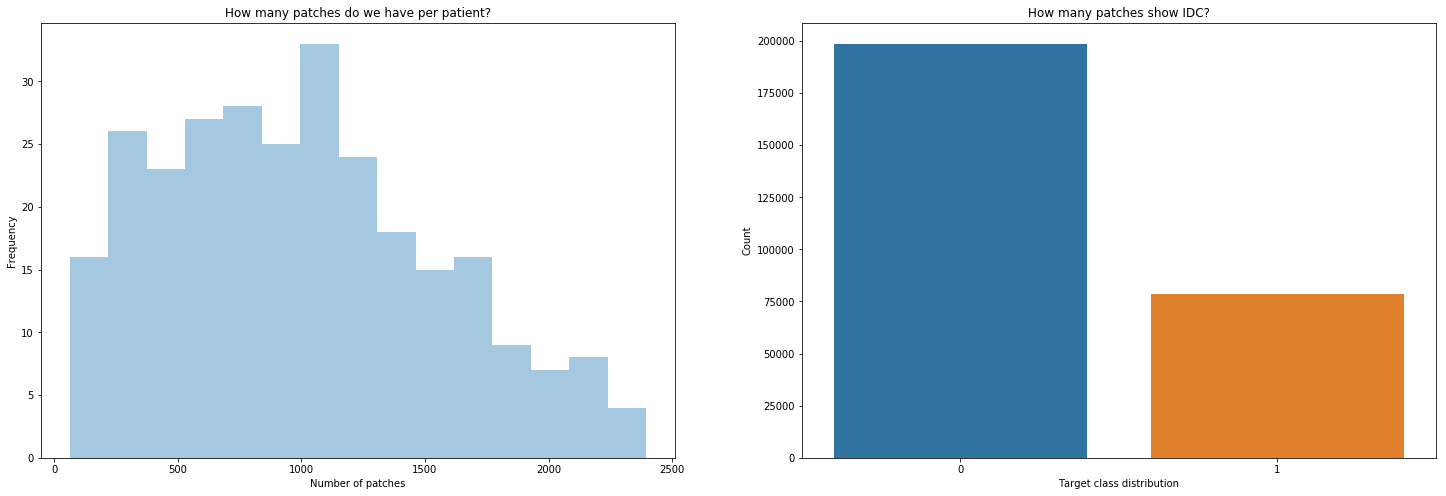

In [19]:
fig, ax = pyplt.subplots(1,2,figsize=(25,8))

# Plotting Frequency of Patches per Patient
sns.distplot(train_df.groupby(['patient_id']).size(), kde=False , bins=15, ax=ax[0])
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

# Plotting number of patches that show IDC
sns.countplot(train_df.target, ax=ax[1])
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Target class distribution")
ax[1].set_title("How many patches show IDC?");

In [20]:
# Average patches per patient
277524/279

994.7096774193549

In [21]:
# Return random sample indexes that are cancer positive and cancer negative of size 50
# replace = False means that no duplication is allowed
positive_tissue = np.random.choice(train_df[train_df.target=='1'].index.values, size=100, replace=False)
negative_tissue = np.random.choice(train_df[train_df.target=='0'].index.values, size=100, replace=False)

n_rows = 10
n_cols = 10

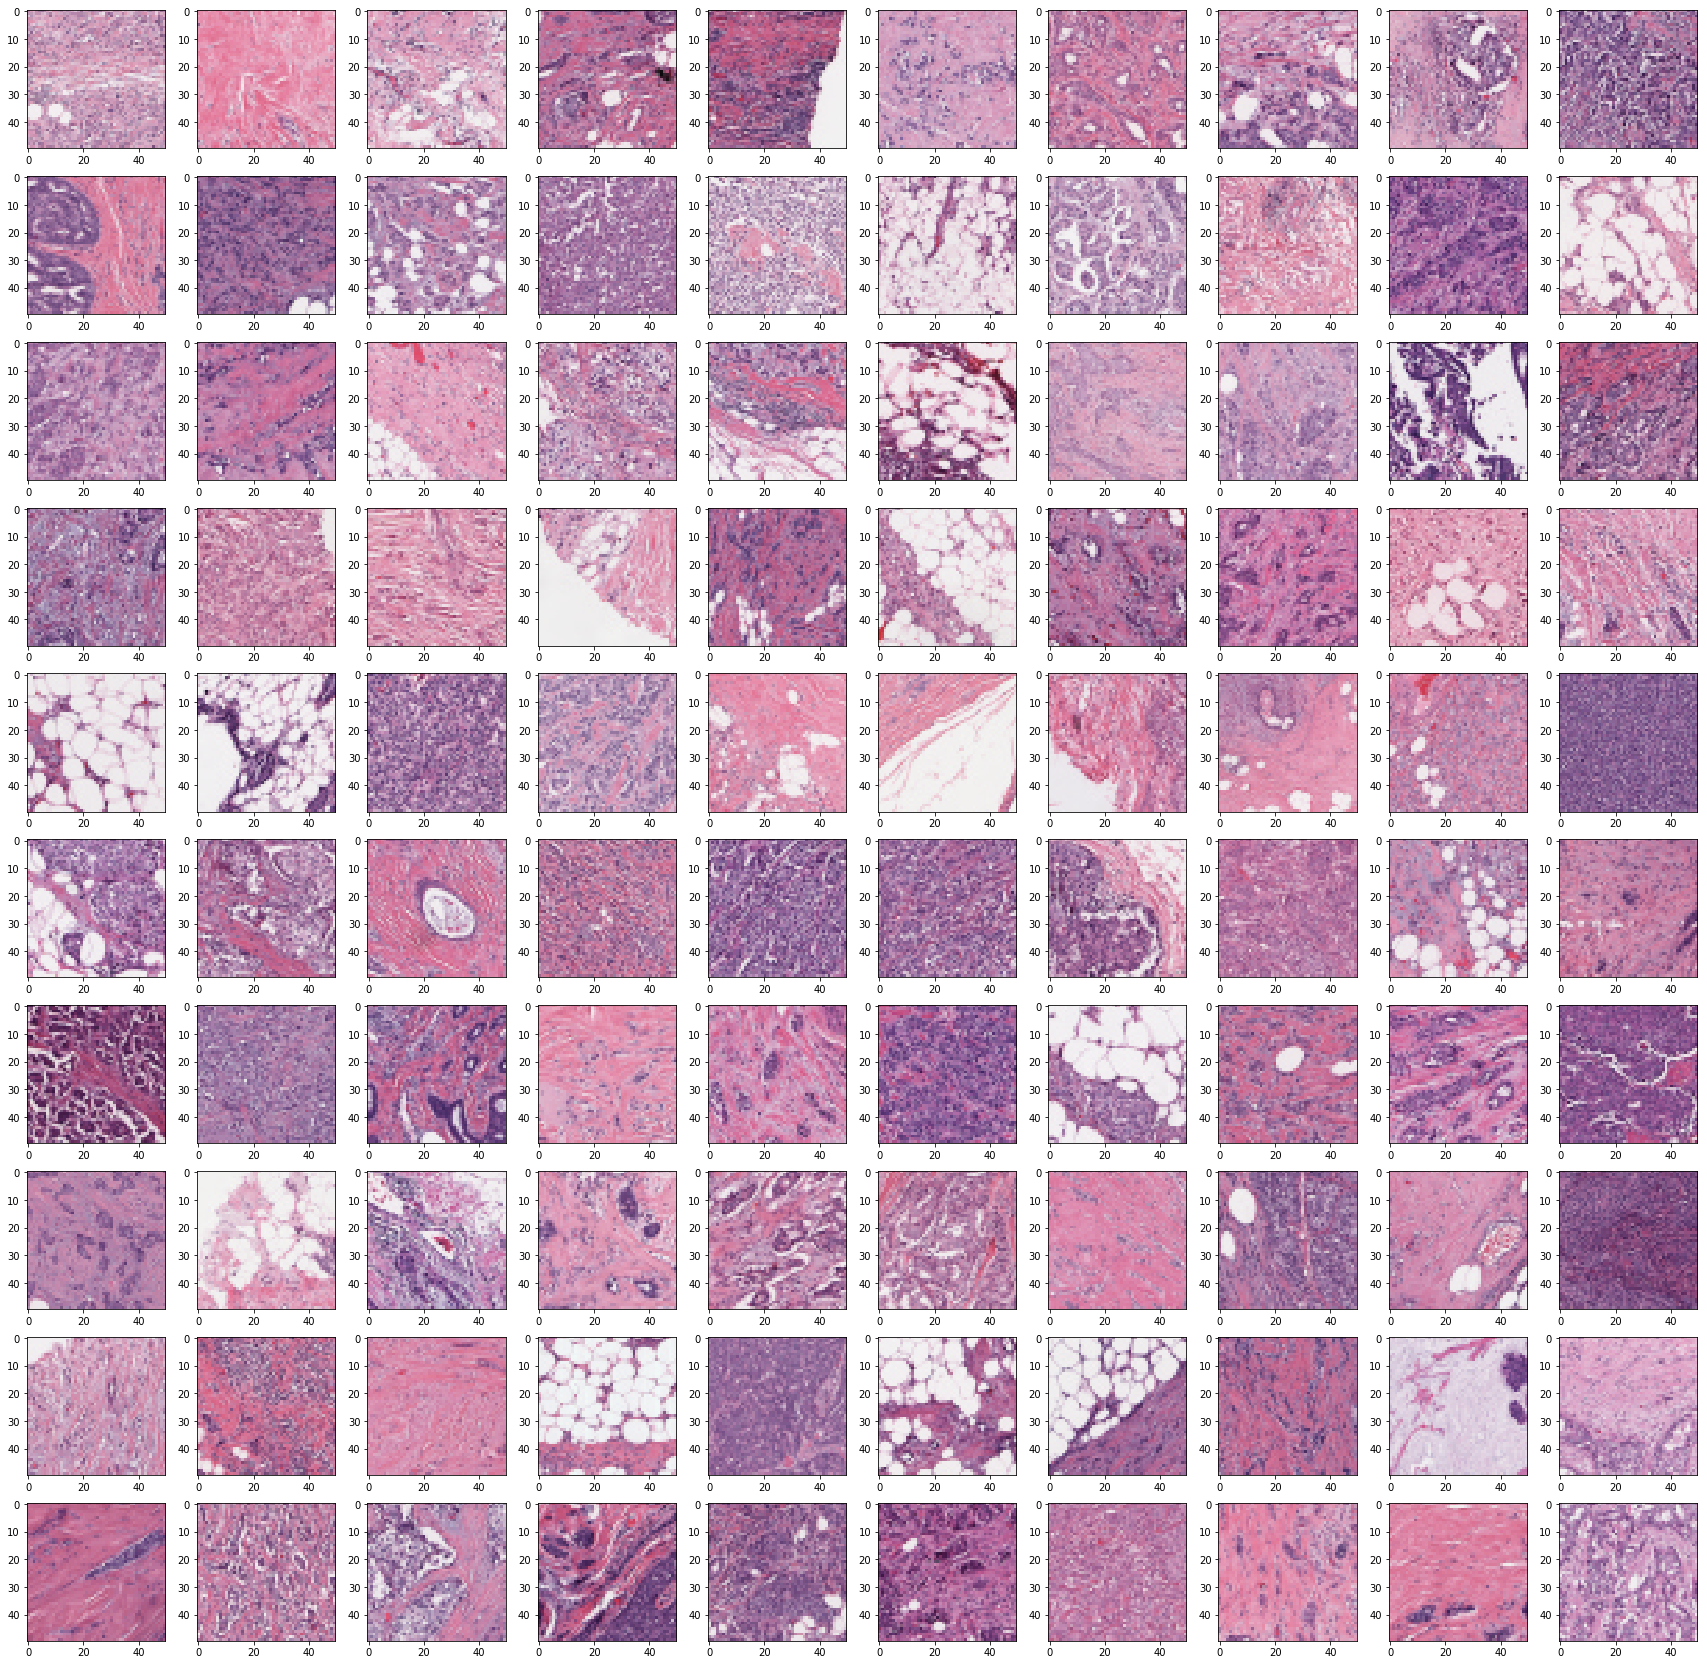

In [22]:
fig,ax = pyplt.subplots(n_rows,n_cols,figsize = (30,30))

for row in range(n_rows):
    for col in range(n_cols):
        # below is a counter to cycle through the image indexes
        idx = positive_tissue[col + n_cols*row]
        img = io.imread(train_df.loc[idx, "path"])
        ax[row,col].imshow(img[:,:,:])
        ax[row,col].grid(False)

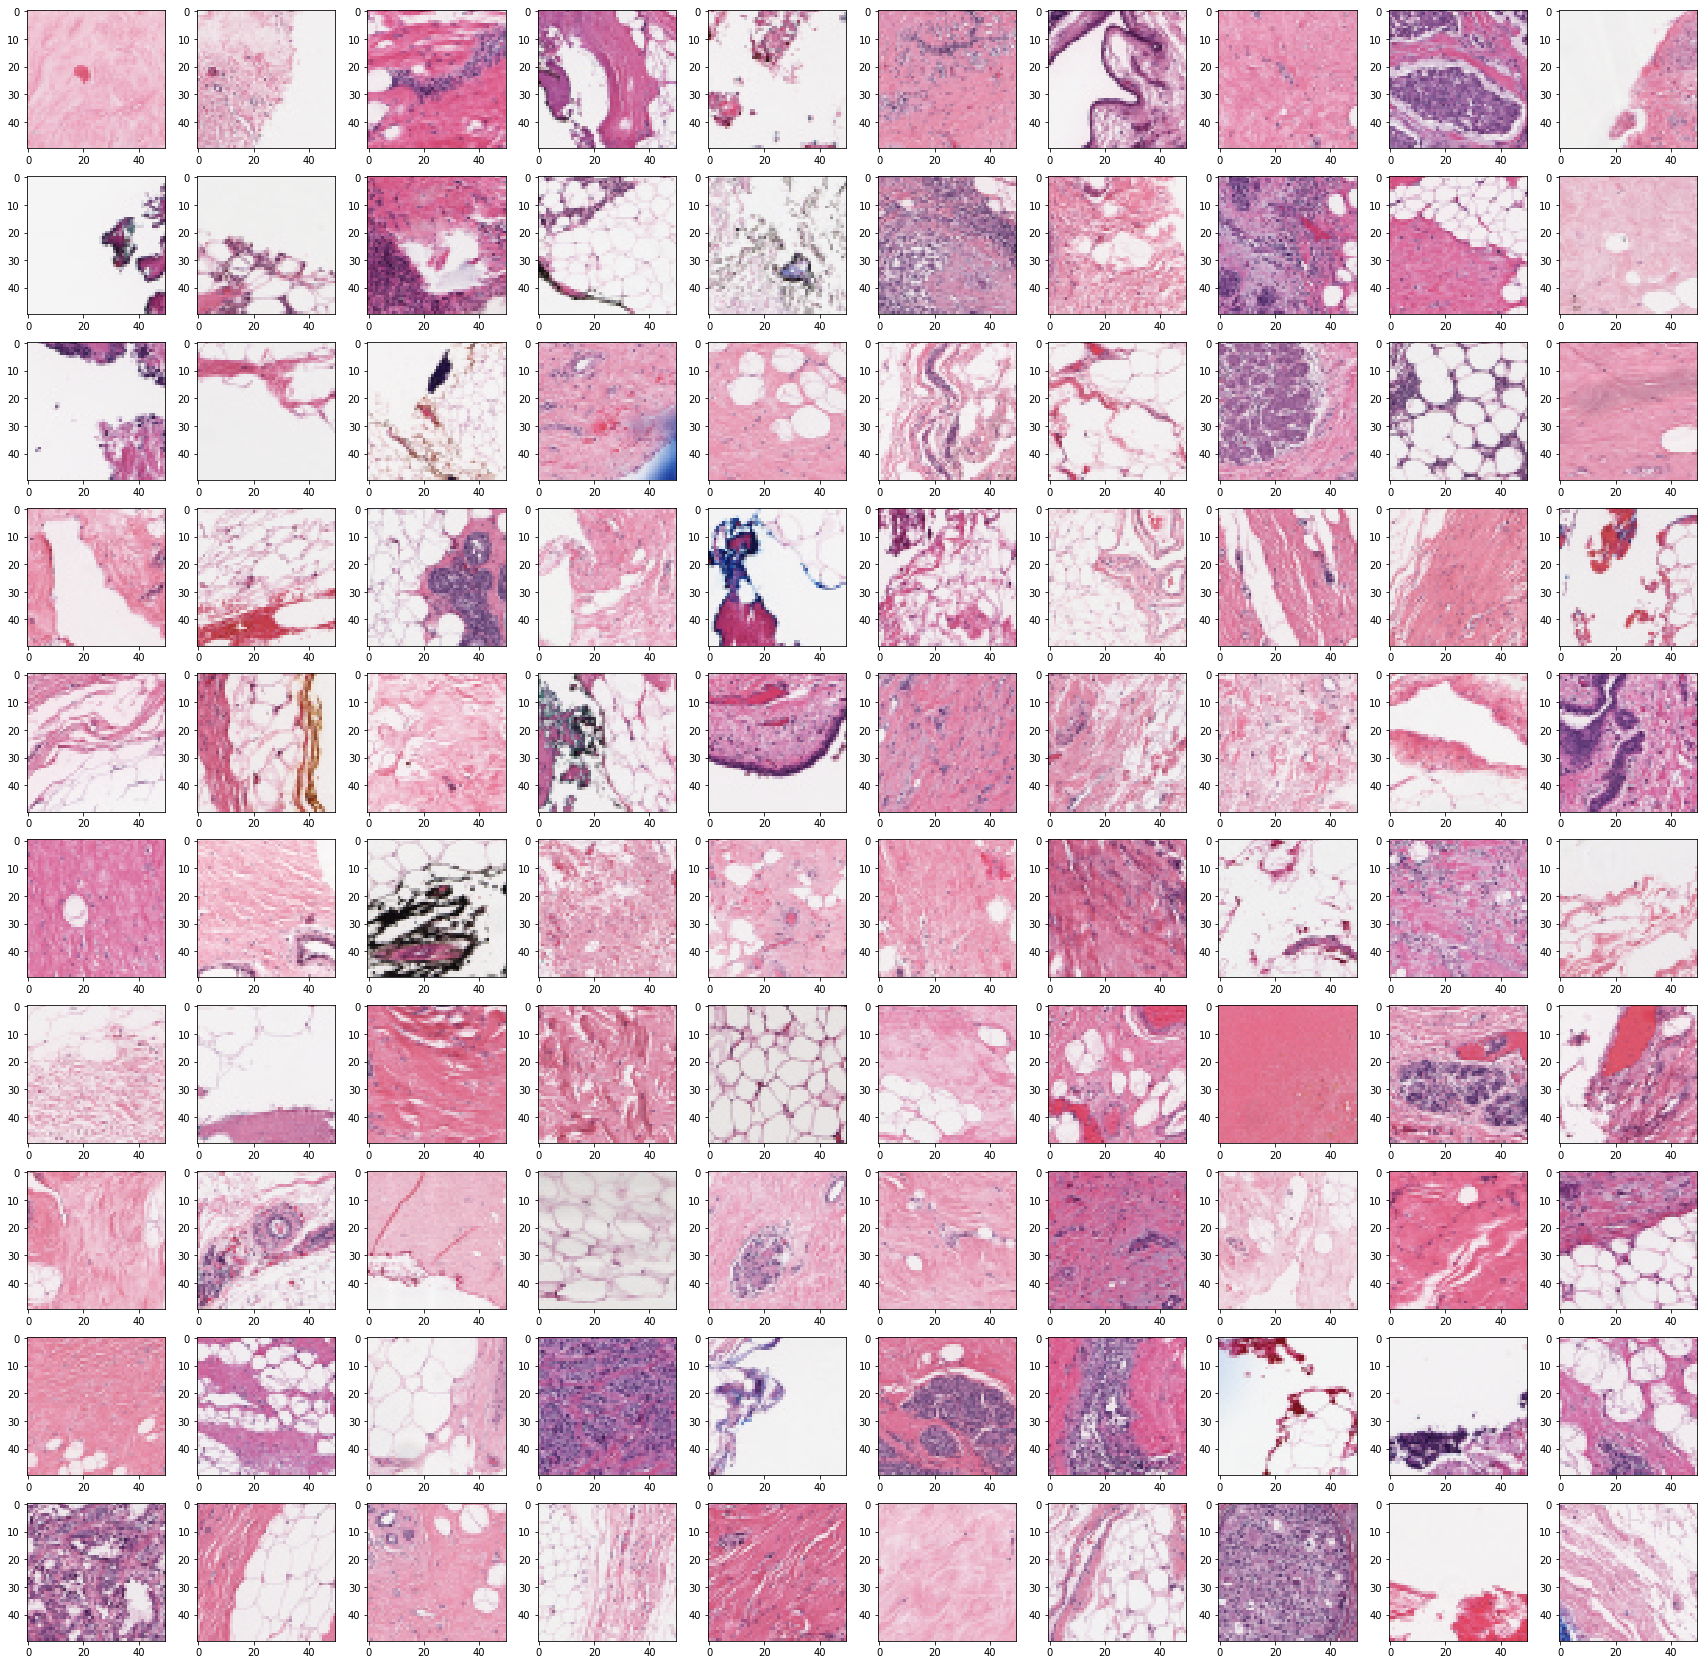

In [23]:
fig,ax = pyplt.subplots(n_rows,n_cols,figsize = (30,30))

for row in range(n_rows):
    for col in range(n_cols):
        # below is a counter to cycle through the image indexes
        idx = negative_tissue[col + n_cols*row]
        img = io.imread(train_df.loc[idx, "path"])
        ax[row,col].imshow(img[:,:,:])
        ax[row,col].grid(False)